In [1]:
import os
import sys
import re
from tqdm import tqdm
from typing import Iterable

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from misc.utils import cached, parse_as

# TODO: This has no effect for some reason (goal is to make graphs in notebook large and hi-res)
plt.rcParams['figure.dpi'] = 300

%matplotlib inline

# User Settings

In [2]:
##################################################
# User Settings
##################################################
# Change these to influence the execution of the
# notebook.
# You can override these from the command line
# by defining environment variables with the
# name of the constants below, prefixed with
# "ANA_NB_".
# For example, the environment variable
# "ANA_NB_TR_PATH" will override the "TR_PATH"
# setting below.
##################################################

# The path to the build folder of a ROS2 workspace that contains the
# tracetools_read and tracetools_analysis folders.
TRACING_WS_BUILD_PATH = "/home/niklas/dataflow-analysis/dependencies/build"

# The name of the experiment that is being analyzed.
# This will be used to name output directory.
EXPERIMENT_NAME = "ros_single_timed_20-20250609154040"

# Path to trace directory (e.g. ~/.ros/my-trace/ust) or to a converted trace file.
# Using the path "/ust" at the end is optional but greatly reduces processing time
# if kernel traces are also present.
TR_PATH = f"/home/niklas/dataflow-analysis/traces/{EXPERIMENT_NAME}/ust"

# Path to the folder all artifacts from this notebook are saved to.
# This entails plots as well as data tables.
OUT_PATH = f"out/{EXPERIMENT_NAME}/"

# Whether to cache the results of long computations per set of inputs
CACHING_ENABLED = False

# Whether to annotate topics/publications with bandwidth/message size
BW_ENABLED = False
# Path to a HDF5 file as output by ma-hw-perf-tools/messages/record.bash
# Used to annotate message sizes in E2E latency calculations
BW_PATH = "path/to/messages.h5"

# Whether to use dependencies extracted by the Clang-tools to supplement
# automatic node-internal data flow annotations.
# If in doubt, set to False.
CL_ENABLED = False
# Path to the output directory of the ROS2 dependency checker.
# Will only be used if CL_ENABLED is True.
CL_PATH = "/path/to/code_analysis/output"

# Whether to compute data flow graphs.
# If you are only interested in E2E latencies, set this to False
DFG_ENABLED = True
# Whether to plot data flow graphs (ignored if DFG_ENABLED is False)
DFG_PLOT = True

# The maximum node namespace hierarchy level to be plotted.
# Top-level (1): e.g. /sensing, /control, etc.
# Level 3: e.g. /sensing/lidar/pointcloud_processor
DFG_MAX_HIER_LEVEL = 100

# RegEx pattern for nodes that shall be marked as system inputs
# These will be plotted with a start arrow as known from automata diagrams
DFG_INPUT_NODE_PATTERNS = [r"^/input_"]
# RegEx pattern for nodes that shall be marked as system outputs
# These will be plotted with a double border
DFG_OUTPUT_NODE_PATTERNS = [r"^/output_"]
# RegEx for nodes which shall not be plotted in the DFG
DFG_EXCL_NODE_PATTERNS = [r"^/rviz2"]

# Whether to compute E2E latencies.
E2E_ENABLED = True
# Whether to plot end-to-end latency information (ignored if E2E_ENABLED is False)
E2E_PLOT = True
# The index of the output message that shall be used in plots that visualize a specific
# message dependency tree. This index has to be 0 <= n < #output messages
E2E_PLOT_TIMESTAMP = 5
# E2E latency threshold. Every E2E latency higher than this is discarded.
# Set this as low as comfortably possible to speed up calculations.
# WARNING: If you set this too low (i.e. to E2E latencies that plausibly can happen)
# your results will be wrong)
E2E_TIME_LIMIT_S = 1000

# All topics containing any of these RegEx patterns are considered output topics in E2E latency calculations
# E.g. r"^/control/" will cover all control topics
E2E_OUTPUT_TOPIC_PATTERNS = [r"^/output/"]
# All topics containing any of these RegEx patterns are considered input topics in E2E latency calculations
# E.g. r"^/sensing/" will cover all sensing topics
E2E_INPUT_TOPIC_PATTERNS = [r"^/input/"]

# E2E paths are uniquely identified by a string like "/topic/1 -> void(Node1)(args1) -> /topic/2 -> void(Node2)(args2) -> void(Node2)(args3) -> ...".
# Certain patterns only occur in initial setup or in scenario switching and can be excluded via RegEx patterns here.
E2E_EXCL_PATH_PATTERNS = [r"^/parameter_events"]

# To specify paths of interest, topic/callback name patterns that HAVE TO OCCUR in each E2E path can be specified as RegEx here.
#E2E_INCL_PATH_PATTERNS = ["BehaviorPathPlanner", "BehaviorVelocityPlanner", "pointcloud_preprocessor::Filter", r"^/sensing/.*?pointcloud"]
E2E_INCL_PATH_PATTERNS = []

# If an exact path through the system is known, this variabe can be set to a list (order matters!) of all elements on the path.
# The first item ist the one at the "input end" of the system, the last one the "output end".
E2E_EXACT_PATH = []

# For development purposes only. Leave this at False.
DEBUG = False

# For development purposes only. Leave this at False.
MANUAL_CACHE = False

##################################################
# End of User Settings
##################################################

# This code overrides the above constants with environment variables, with values from the environment.
# Values will be parsed through Python's literal_eval() function. Thus, strings have to be specified
# including " or '.
for env_key, env_value in os.environ.items():
    if env_key.startswith("ANA_NB_"):
        key = env_key.removeprefix("ANA_NB_")
        if key not in globals().keys():
            continue
        value = parse_as(type(globals()[key]), env_value)
        globals()[key] = value


# Convert input paths to absolute paths
def _expand_path(path):
    return os.path.realpath(os.path.expandvars(os.path.expanduser(path)))


TRACING_WS_BUILD_PATH = _expand_path(TRACING_WS_BUILD_PATH)
TR_PATH = _expand_path(TR_PATH)
OUT_PATH = _expand_path(OUT_PATH)
BW_PATH = _expand_path(BW_PATH)
CL_PATH = _expand_path(CL_PATH)

os.makedirs(OUT_PATH, exist_ok=True)

# Print parsed user settings
print("User Settings:")
for k, v in globals().copy().items():
    if not k.isupper():
        continue
    if isinstance(v, Iterable) and not isinstance(v, str):
        v = ("\n  " + (" " * 44)).join(list(map(str, v)))
    print(f"  {k:.<40s} := {v}")

User Settings:
  TRACING_WS_BUILD_PATH................... := /home/niklas/dataflow-analysis/dependencies/build
  EXPERIMENT_NAME......................... := ros_single_timed_20-20250609154040
  TR_PATH................................. := /home/niklas/dataflow-analysis/traces/ros_single_timed_20-20250609154040/ust
  OUT_PATH................................ := /home/niklas/dataflow-analysis/out/ros_single_timed_20-20250609154040
  CACHING_ENABLED......................... := False
  BW_ENABLED.............................. := False
  BW_PATH................................. := /home/niklas/dataflow-analysis/path/to/messages.h5
  CL_ENABLED.............................. := False
  CL_PATH................................. := /path/to/code_analysis/output
  DFG_ENABLED............................. := True
  DFG_PLOT................................ := True
  DFG_MAX_HIER_LEVEL...................... := 100
  DFG_INPUT_NODE_PATTERNS................. := ^/input_
  DFG_OUTPUT_NODE_PATTERNS.......

In [3]:
# The last few imports can only be resolved using the user-specified paths above
sys.path.append(os.path.join(TRACING_WS_BUILD_PATH, "tracetools_read/"))
sys.path.append(os.path.join(TRACING_WS_BUILD_PATH, "tracetools_analysis/"))
# noinspection PyUnresolvedReferences
from tracetools_read.trace import *
# noinspection PyUnresolvedReferences
from tracetools_analysis.loading import load_file
# noinspection PyUnresolvedReferences
from tracetools_analysis.processor.ros2 import Ros2Handler

from tracing_interop.tr_types import *

# Load Trace Data

Load (and, if necessary, convert) tracing data obtained through ros2_tracing. Build indices for fast analysis.

In [4]:
def _load_traces():
    file = load_file(TR_PATH)
    handler = Ros2Handler.process(file)
    return TrContext(handler)


_tracing_context = cached("tr_objects", _load_traces, [TR_PATH], not CACHING_ENABLED)
_tr_globals = ["nodes", "publishers", "subscriptions", "timers", "timer_node_links", "subscription_objects",
               "callback_objects", "callback_symbols", "publish_instances", "callback_instances", "topics"]

# Help the IDE recognize those identifiers by assigning a dummy value to their name.
nodes: Index = Index([])
publishers: Index = Index([])
subscriptions: Index = Index([])
timers: Index = Index([])
timer_node_links: Index = Index([])
subscription_objects: Index = Index([])
callback_objects: Index = Index([])
callback_symbols: Index = Index([])
publish_instances: Index = Index([])
callback_instances: Index = Index([])
topics: Index = Index([])

for name in _tr_globals:
    globals()[name] = getattr(_tracing_context, name)

print("Done.")

[CACHE] Cache disabled for tr_objects.
found converted file: /home/niklas/dataflow-analysis/traces/ros_single_timed_20-20250609154040/ust/converted
 [100%] [Ros2Handler]
[TrContext] Processing ROS 2 objects from traces...


 ├─ Processing TrPublishers: 100%|██████████| 69/69 [00:00<00:00, 404765.00it/s]


[DEBUG] Duplicate Indices in id


 ├─ Processing TrCallbackInstances: 100%|██████████| 4208/4208 [00:00<00:00, 781302.84it/s]

Done.


In [5]:
##################################################
# Print (All/Input/Output) Topic Message Counts
##################################################

for topic in sorted(topics, key=lambda t: t.name):
    topic: TrTopic
    print(f"{topic.name:.<130s} | {sum(map(lambda p: len(p.instances), topic.publishers)):>5d} msgs")

print("\n[DEBUG] INPUT TOPICS")
for t in sorted(topics, key=lambda t: t.name):
    for f in E2E_INPUT_TOPIC_PATTERNS:
        if re.search(f, t.name):
            print(f"--[DEBUG] {f:<30s}:{t.name:.<89s} | {sum(map(lambda p: len(p.instances), t.publishers)):>5d} msgs")

print("\n[DEBUG] OUTPUT TOPICS")
for t in sorted(topics, key=lambda t: t.name):
    for f in E2E_OUTPUT_TOPIC_PATTERNS:
        if re.search(f, t.name):
            print(f"--[DEBUG] {f:<30s}:{t.name:.<89s} | {sum(map(lambda p: len(p.instances), t.publishers)):>5d} msgs")

/cameraA/debayered................................................................................................................ |    97 msgs
/cameraA/geometric................................................................................................................ |    96 msgs
/cameraA/radiometric.............................................................................................................. |    97 msgs
/cameraB/debayered................................................................................................................ |   115 msgs
/cameraB/radiometric.............................................................................................................. |   114 msgs
/flight/plan...................................................................................................................... |   127 msgs
/input/baroA/alt.................................................................................................................. |   1

# Analyze ROS Graph
Reconstruct namespace hierarchy, data flow graph between callbacks.

In [6]:
import latency_graph.latency_graph_structure as lg


def _make_latency_graph():
    return lg.LatencyGraph(_tracing_context)


lat_graph = cached("lat_graph", _make_latency_graph, [TR_PATH], not CACHING_ENABLED)

[CACHE] Cache disabled for lat_graph.


Finding CB nodes: 100%|██████████| 195/195 [00:00<00:00, 288192.14it/s]


[DEBUG] 138 callbacks have no owner, filtering them out.


Building graph nodes: 100%|██████████| 57/57 [00:00<00:00, 2461.40it/s]


## Plot ROS Graph (full)
Plot the DFG hierarchically by node namespace. Plot each internal and external dependency between callbacks as one arrow.

  Processing INPUT: 1
  Processing OUTPUT: 1
  Processing input_cameraA_node: 2
  Processing debayerA_node: 2
  Processing radiometricA_node: 2
  Processing geometric_node: 2
  Processing output_mapping_node: 2
  Processing input_cameraB_node: 2
  Processing debayerB_node: 2
  Processing radiometricB_node: 2
  Processing output_smoke_classifier_node: 2
  Processing input_gpsA_node: 2
  Processing input_imuA_node: 2
  Processing input_baroA_node: 2
  Processing fusionA_node: 5
  Processing input_lidar_node: 2
  Processing input_cmd_node: 2
  Processing mgmt_node: 5
  Processing output_control_node: 2
  Processing input_gpsB_node: 2
  Processing input_imuB_node: 2
  Processing input_baroB_node: 2
  Processing fusionB_node: 5
  Processing telemetry_node: 4
  Processing output_radio_node: 2


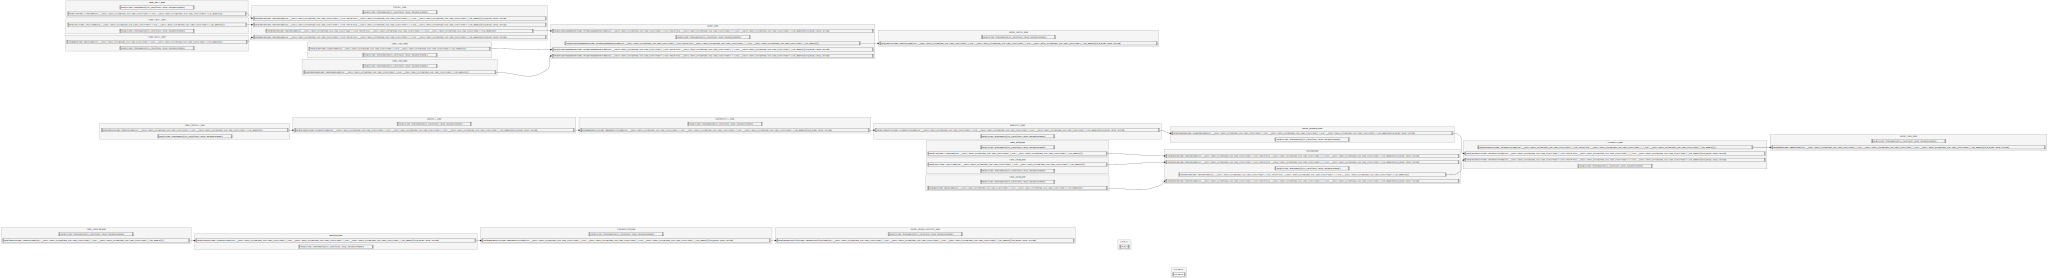

In [7]:
%%skip_if_false DFG_ENABLED
%%skip_if_false DFG_PLOT

#################################################
# Plot full DFG, down to the callback level
#################################################

from latency_graph.latency_graph_plots import plot_latency_graph_full

plot_latency_graph_full(lat_graph, _tracing_context, os.path.join(OUT_PATH, "latency_graph_full"))

## Plot Latency Graph (overview)
Plot the DFG down to a certain hierarchy level in a flattened manner. Aggregate dependencies from multiple callbacks into corresponding node-node dependencies.

Plotting DFG overview with max hierarchy level 100...
Input Node Patterns: ['^/input_']
Output Node Patterns: ['^/output_']
Excluded Node Patterns: ['^/rviz2']
Input Nodes: /input_cameraA_node, /input_cameraB_node, /input_gpsA_node, /input_imuA_node, /input_baroA_node, /input_lidar_node, /input_cmd_node, /input_gpsB_node, /input_imuB_node, /input_baroB_node
Output Nodes: /output_mapping_node, /output_smoke_classifier_node, /output_control_node, /output_radio_node
Intermediate Nodes: /INPUT, /OUTPUT, /input_cameraA_node, /debayerA_node, /radiometricA_node, /geometric_node, /output_mapping_node, /input_cameraB_node, /debayerB_node, /radiometricB_node, /output_smoke_classifier_node, /input_gpsA_node, /input_imuA_node, /input_baroA_node, /fusionA_node, /input_lidar_node, /input_cmd_node, /mgmt_node, /output_control_node, /input_gpsB_node, /input_imuB_node, /input_baroB_node, /fusionB_node, /telemetry_node, /output_radio_node
/input_baroA_node /fusionA_node 1
/telemetry_node /output_radio_n

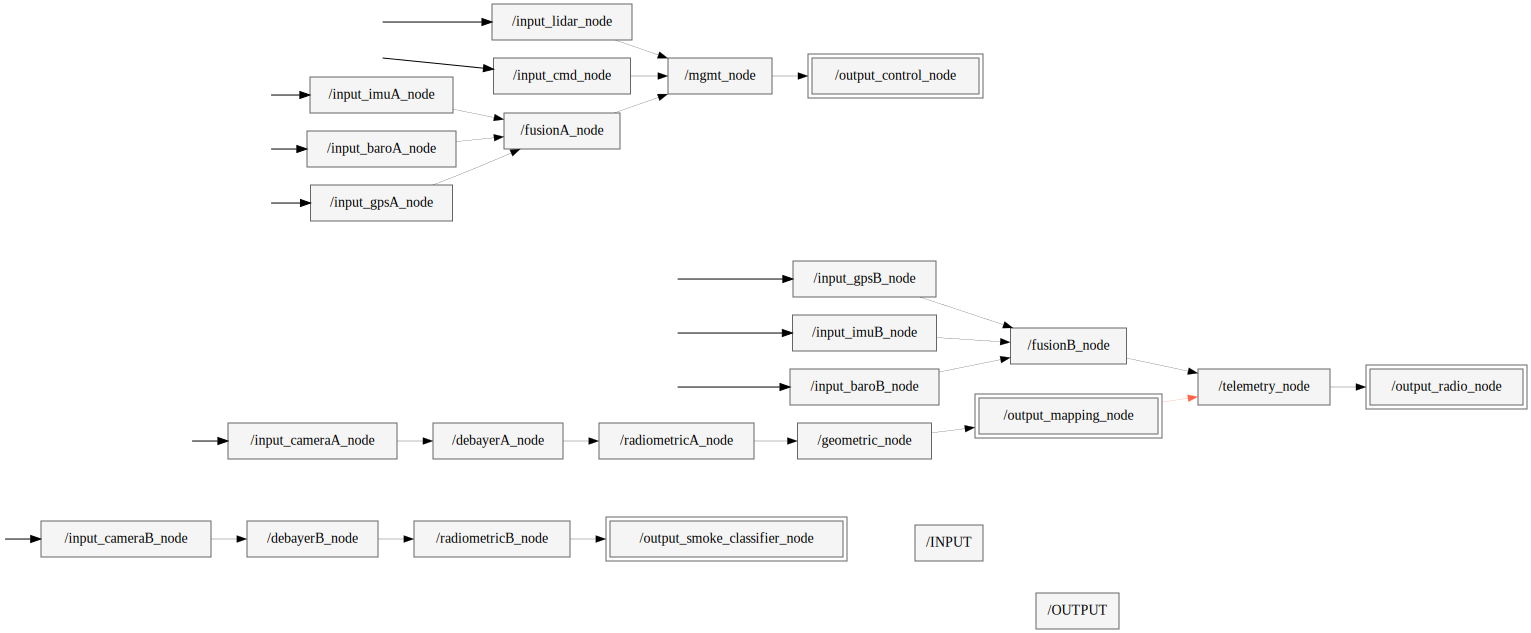

In [8]:
%%skip_if_false DFG_ENABLED
%%skip_if_false DFG_PLOT

#################################################
# Plot overview of DFG, down to a certain
# hierarchy level
#################################################

from latency_graph.latency_graph_plots import plot_latency_graph_overview

print(f"Plotting DFG overview with max hierarchy level {DFG_MAX_HIER_LEVEL}...")
print(f"Input Node Patterns: {DFG_INPUT_NODE_PATTERNS}")
print(f"Output Node Patterns: {DFG_OUTPUT_NODE_PATTERNS}")
print(f"Excluded Node Patterns: {DFG_EXCL_NODE_PATTERNS}")

plot_latency_graph_overview(lat_graph, DFG_EXCL_NODE_PATTERNS, DFG_INPUT_NODE_PATTERNS, DFG_OUTPUT_NODE_PATTERNS, DFG_MAX_HIER_LEVEL, os.path.join(OUT_PATH, "latency_graph_overview"))

# Analyze Message Flow
Build dependency trees ending in the specified output topics.

In [9]:
%%skip_if_false E2E_ENABLED

from message_tree.message_tree_algorithms import build_dep_trees

end_topics = [t for t in _tracing_context.topics if any(re.search(f, t.name) for f in E2E_OUTPUT_TOPIC_PATTERNS)]

print(f"Found {len(end_topics)} end topics for E2E latency calculations: {', '.join(t.name for t in end_topics)}")

print(f"Using {len(_tracing_context.callback_objects)} callback objects, {len(_tracing_context.callback_instances)} callback instances, and {len(_tracing_context.publish_instances)} publish instances for E2E latency calculations.")

def _build_dep_trees():
    return build_dep_trees(end_topics, lat_graph, _tracing_context, E2E_EXCL_PATH_PATTERNS, E2E_TIME_LIMIT_S)
    #return build_dep_trees(end_topics, lat_graph, _tracing_context, E2E_EXCL_PATH_PATTERNS, E2E_TIME_LIMIT_S, exact_path=E2E_EXACT_PATH)

try:
    trees = cached("trees", _build_dep_trees, [TR_PATH], not CACHING_ENABLED)
except Exception as e:
    import traceback
    print(e)
    traceback.print_exc()

Found 4 end topics for E2E latency calculations: /output/flight/cmd, /output/telemetry/radio, /output/cameraA/mapped, /output/classifier/classification
Using 195 callback objects, 4208 callback instances, and 2688 publish instances for E2E latency calculations.
[CACHE] Cache disabled for trees.
=====/output/flight/cmd


Processing output messages: 100%|██████████| 125/125 [00:01<00:00, 73.48it/s]


Found 125 trees for topic /output/flight/cmd
=====/output/telemetry/radio


Processing output messages: 100%|██████████| 127/127 [00:01<00:00, 78.03it/s]


Found 127 trees for topic /output/telemetry/radio
=====/output/cameraA/mapped


Processing output messages: 100%|██████████| 95/95 [00:00<00:00, 1460.40it/s]


Found 95 trees for topic /output/cameraA/mapped
=====/output/classifier/classification


Processing output messages: 100%|██████████| 112/112 [00:00<00:00, 281.79it/s]

Found 112 trees for topic /output/classifier/classification


In [10]:
%%skip_if_false E2E_ENABLED
%%skip_if_false BW_ENABLED

##################################################
# Get message bandwidths from `ros2 multitopic bw`
# output.
##################################################

from bw_interop.process_bw_output import get_topic_messages
msgs = get_topic_messages(BW_PATH)

from bw_interop.bw_plots import dds_lat_msg_size_scatter
plot_topic = ""

'Skipped (evaluated BW_ENABLED to False)'

In [11]:
%%skip_if_false E2E_ENABLED

from message_tree.message_tree_algorithms import e2e_paths_sorted_desc
from message_tree.message_tree_algorithms import owner
from message_tree.message_tree_structure import DepTree

# set of seen publush topics to avoid duplicates
seen_publish_topics = set()

def _print_elem(elem, indent=0):
    if isinstance(elem, TrTopic):
        print(f"{' ' * indent}Topic: {elem.name}")
    elif isinstance(elem, TrCallbackObject):
        print(f"{' ' * indent}Callback: {elem.name} ({elem.elem.name})")
    elif isinstance(elem, TrPublishInstance):
        #if elem.publisher.topic_name in seen_publish_topics:
        #    print(f"{' ' * indent}Publish Instance: {elem.publisher.topic_name} (already seen)")
        #    return False
        #seen_publish_topics.add(elem.publisher.topic_name)
        print(f"{' ' * indent}Publish Instance: {elem.publisher.topic_name}")
    elif isinstance(elem, TrCallbackInstance):
        print(f"{' ' * indent}Callback Instance: {elem.callback_obj.callback_symbol.symbol}")
    else:
        print(f"{' ' * indent}Unknown element type: {type(elem)}")
    return True

def _traverse_print_tree(tree, indent=0):
    """Recursively traverse a dependency tree and print its structure."""
    for i, node in enumerate(tree):
        if isinstance(node, DepTree):
            if not _print_elem(node.head, indent):
                continue
            _traverse_print_tree(node.deps, indent + 2)
        elif isinstance(node, list):
            for entry in node:
                if entry is not None and isinstance(entry, DepTree):
                    if not _print_elem(entry.head, indent):
                        continue
                    _traverse_print_tree(entry.deps, indent + 2)
                else:
                    print(f"{' ' * indent}List of {len(node)} elements, but not a DepTree.")
        else:
            if not _print_elem(node, indent):
                continue

def _print_trees():
    print("Dependency Trees:")
    for i, tree in enumerate(trees):
        print(f"\nTree {i + 1}/{len(trees)}:")
        _traverse_print_tree(tree)
    print("\nEnd of Dependency Trees\n")
    print(f"Published topics seen so far: {len(seen_publish_topics)}:, {', '.join(seen_publish_topics)}")
#_print_trees()


##################################################
# Find and filter relevant E2E paths in trees
##################################################
trees_paths = [e2e_paths_sorted_desc(tree, E2E_INPUT_TOPIC_PATTERNS) for tree in tqdm(trees, mininterval=10.0, desc="Extracting E2E paths")]
all_paths = [p for paths in trees_paths for p in paths]

def _print_paths():
    for i, path in enumerate(all_paths):
        print(f"Path {i+1}/{len(all_paths)}:")
        for j, elem in enumerate(path):
            if isinstance(elem, TrTopic):
                print(f"  {j+1:>3d}: Topic: {elem.name}")
            elif isinstance(elem, TrCallbackObject):
                print(f"  {j+1:>3d}: Callback: {elem.name} ({elem.node.name})")
            elif isinstance(elem, TrPublishInstance):
                print(f"  {j+1:>3d}: Publish Instance: {elem.publisher.topic_name}")
            elif isinstance(elem, TrCallbackInstance):
                print(f"  {j+1:>3d}: Callback Instance: {elem.callback_obj.callback_symbol.symbol}")
            else:
                print(f"  {j+1:>3d}: Unknown element type: {elem}")
        print()
#_print_paths()

print(f"Found {len(all_paths)} E2E paths in total.")

Extracting E2E paths: 100%|██████████| 459/459 [00:00<00:00, 24623.78it/s]

Found 1298 E2E paths in total.


In [12]:
%%skip_if_false E2E_ENABLED

from message_tree.message_tree_algorithms import aggregate_e2e_paths

##################################################
# Group dataflows by DFG path
##################################################

cohorts = aggregate_e2e_paths(all_paths)
print(f"Found {len(cohorts)} cohorts of E2E paths.")
cohort_pairs = [(k, v) for k, v in cohorts.items()]
cohort_pairs.sort(key=lambda kv: len(kv[1]), reverse=True)

path_records = [{"path": path_key,
                 "timestamp": path[-1].timestamp,
                 "e2e_latency": path[-1].timestamp - path[0].timestamp} \
                for path_key, paths in cohort_pairs for path in paths if path]

out_df = pd.DataFrame.from_records(path_records)
out_df.to_csv(os.path.join(OUT_PATH, "e2e.csv"), sep="\t", index=False)

df_print = out_df[['path', 'e2e_latency']].groupby("path").agg(['count', 'mean', 'min', 'max']).reset_index()
#df_print['path'] = df_print['path'].apply(lambda path: " -> ".join(filter(lambda part: part.startswith("/"), path.split(" -> "))))
df_print = df_print.sort_values(("e2e_latency", "count"), ascending=False)
df_print.to_csv(os.path.join(OUT_PATH, "e2e_overview.csv"), sep="\t", index=False)
df_print

Aggregating E2E path cohorts: 100%|██████████| 1298/1298 [00:00<00:00, 256306.51it/s]

Found 11 cohorts of E2E paths.


path e2e_latency            \
                                                            count      mean   
6   void(GPSNode::GPSNode(std::__cxx11::basic_stri...         123  0.472754   
10  void(LidarNode::LidarNode(std::__cxx11::basic_...         123  0.305507   
0   void(BaroNode::BaroNode(std::__cxx11::basic_st...         122  0.475270   
8   void(IMUNode::IMUNode(std::__cxx11::basic_stri...         122  0.477690   
5   void(CommandNode::CommandNode(std::__cxx11::ba...         122  0.304512   
7   void(GPSNode::GPSNode(std::__cxx11::basic_stri...         121  0.458383   
1   void(BaroNode::BaroNode(std::__cxx11::basic_st...         120  0.456218   
9   void(IMUNode::IMUNode(std::__cxx11::basic_stri...         120  0.458216   
3   void(CameraNode::CameraNode(std::__cxx11::basi...         118  0.831055   
4   void(CameraNode::CameraNode(std::__cxx11::basi...         112  0.174314   
2   void(CameraNode::CameraNode(std::__cxx11::basi...          95  0.379984   

                        
         min       max  
6   0.155679  0.589257  
10  0.134326  0.384916  
0   0.180133  0.629801  
8   0.155617  0.636953  
5   0.139173  0.382762  
7   0.172521  0.567640  
1   0.205201  0.565442  
9   0.205263  0.565517  
3   0.320465  1.448288  
4   0.117773  0.584865  
2   0.074686  0.810526

In [13]:
import pickle
# with open("state.pkl", "wb") as f:
#     pickle.dump((trees_paths, all_paths, cohorts), f)
with open(os.path.join(OUT_PATH, "state.pkl"), "wb") as f:
    pickle.dump((trees_paths, all_paths, cohorts), f)

Calculating breakdowns: 100%|██████████| 123/123 [00:00<00:00, 91439.10it/s]


Labels: ['GPSNode', '/input/gpsA/fix', 'FusionNode', '/fusionA_node', 'FusionNode', '/sensorsA/fused', 'FlightManagementNode', '/mgmt_node', 'FlightManagementNode', '/flight/plan', 'ControlNode']


Calculating breakdowns: 100%|██████████| 123/123 [00:00<00:00, 134769.96it/s]


Labels: ['LidarNode', '/input/lidar/scan', 'FlightManagementNode', '/mgmt_node', 'FlightManagementNode', '/flight/plan', 'ControlNode']


Calculating breakdowns: 100%|██████████| 122/122 [00:00<00:00, 90263.73it/s]


Labels: ['IMUNode', '/input/imuA/data', 'FusionNode', '/fusionA_node', 'FusionNode', '/sensorsA/fused', 'FlightManagementNode', '/mgmt_node', 'FlightManagementNode', '/flight/plan', 'ControlNode']


Calculating breakdowns: 100%|██████████| 122/122 [00:00<00:00, 65368.56it/s]


Labels: ['BaroNode', '/input/baroA/alt', 'FusionNode', '/fusionA_node', 'FusionNode', '/sensorsA/fused', 'FlightManagementNode', '/mgmt_node', 'FlightManagementNode', '/flight/plan', 'ControlNode']


Calculating breakdowns: 100%|██████████| 122/122 [00:00<00:00, 130271.15it/s]


Labels: ['CommandNode', '/input/operator/commands', 'FlightManagementNode', '/mgmt_node', 'FlightManagementNode', '/flight/plan', 'ControlNode']


/tmp/ipykernel_256141/3060490163.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, num=f"E2E type breakdown histograms {name}\n{EXPERIMENT_NAME}", dpi=300, figsize=(16, 9))
Calculating breakdowns: 100%|██████████| 121/121 [00:00<00:00, 98126.60it/s]


Labels: ['GPSNode', '/input/gpsB/fix', 'FusionNode', '/fusionB_node', 'FusionNode', '/sensorsB/fused', 'TelemetryNode', '/telemetry_node', 'TelemetryNode', '/telemetry/data', 'RadioNode']


Calculating breakdowns: 100%|██████████| 120/120 [00:00<00:00, 98342.42it/s]


Labels: ['IMUNode', '/input/imuB/data', 'FusionNode', '/fusionB_node', 'FusionNode', '/sensorsB/fused', 'TelemetryNode', '/telemetry_node', 'TelemetryNode', '/telemetry/data', 'RadioNode']


Calculating breakdowns: 100%|██████████| 120/120 [00:00<00:00, 98074.14it/s]


Labels: ['BaroNode', '/input/baroB/alt', 'FusionNode', '/fusionB_node', 'FusionNode', '/sensorsB/fused', 'TelemetryNode', '/telemetry_node', 'TelemetryNode', '/telemetry/data', 'RadioNode']


Calculating breakdowns: 100%|██████████| 118/118 [00:00<00:00, 53662.35it/s]


Labels: ['CameraNode', '/input/cameraA/raw', 'DebayerNode', '/cameraA/debayered', 'RadiometricNode', '/cameraA/radiometric', 'GeometricNode', '/cameraA/geometric', 'MappingNode', '/output/cameraA/mapped', 'TelemetryNode', '/telemetry_node', 'TelemetryNode', '/telemetry/data', 'RadioNode']


Calculating breakdowns: 100%|██████████| 95/95 [00:00<00:00, 113715.43it/s]


Labels: ['CameraNode', '/input/cameraA/raw', 'DebayerNode', '/cameraA/debayered', 'RadiometricNode', '/cameraA/radiometric', 'GeometricNode', '/cameraA/geometric', 'MappingNode']


Calculating breakdowns: 100%|██████████| 112/112 [00:00<00:00, 137357.32it/s]


Labels: ['CameraNode', '/input/cameraB/raw', 'DebayerNode', '/cameraB/debayered', 'RadiometricNode', '/cameraB/radiometric', 'SmokeClassifierNode']
Done.


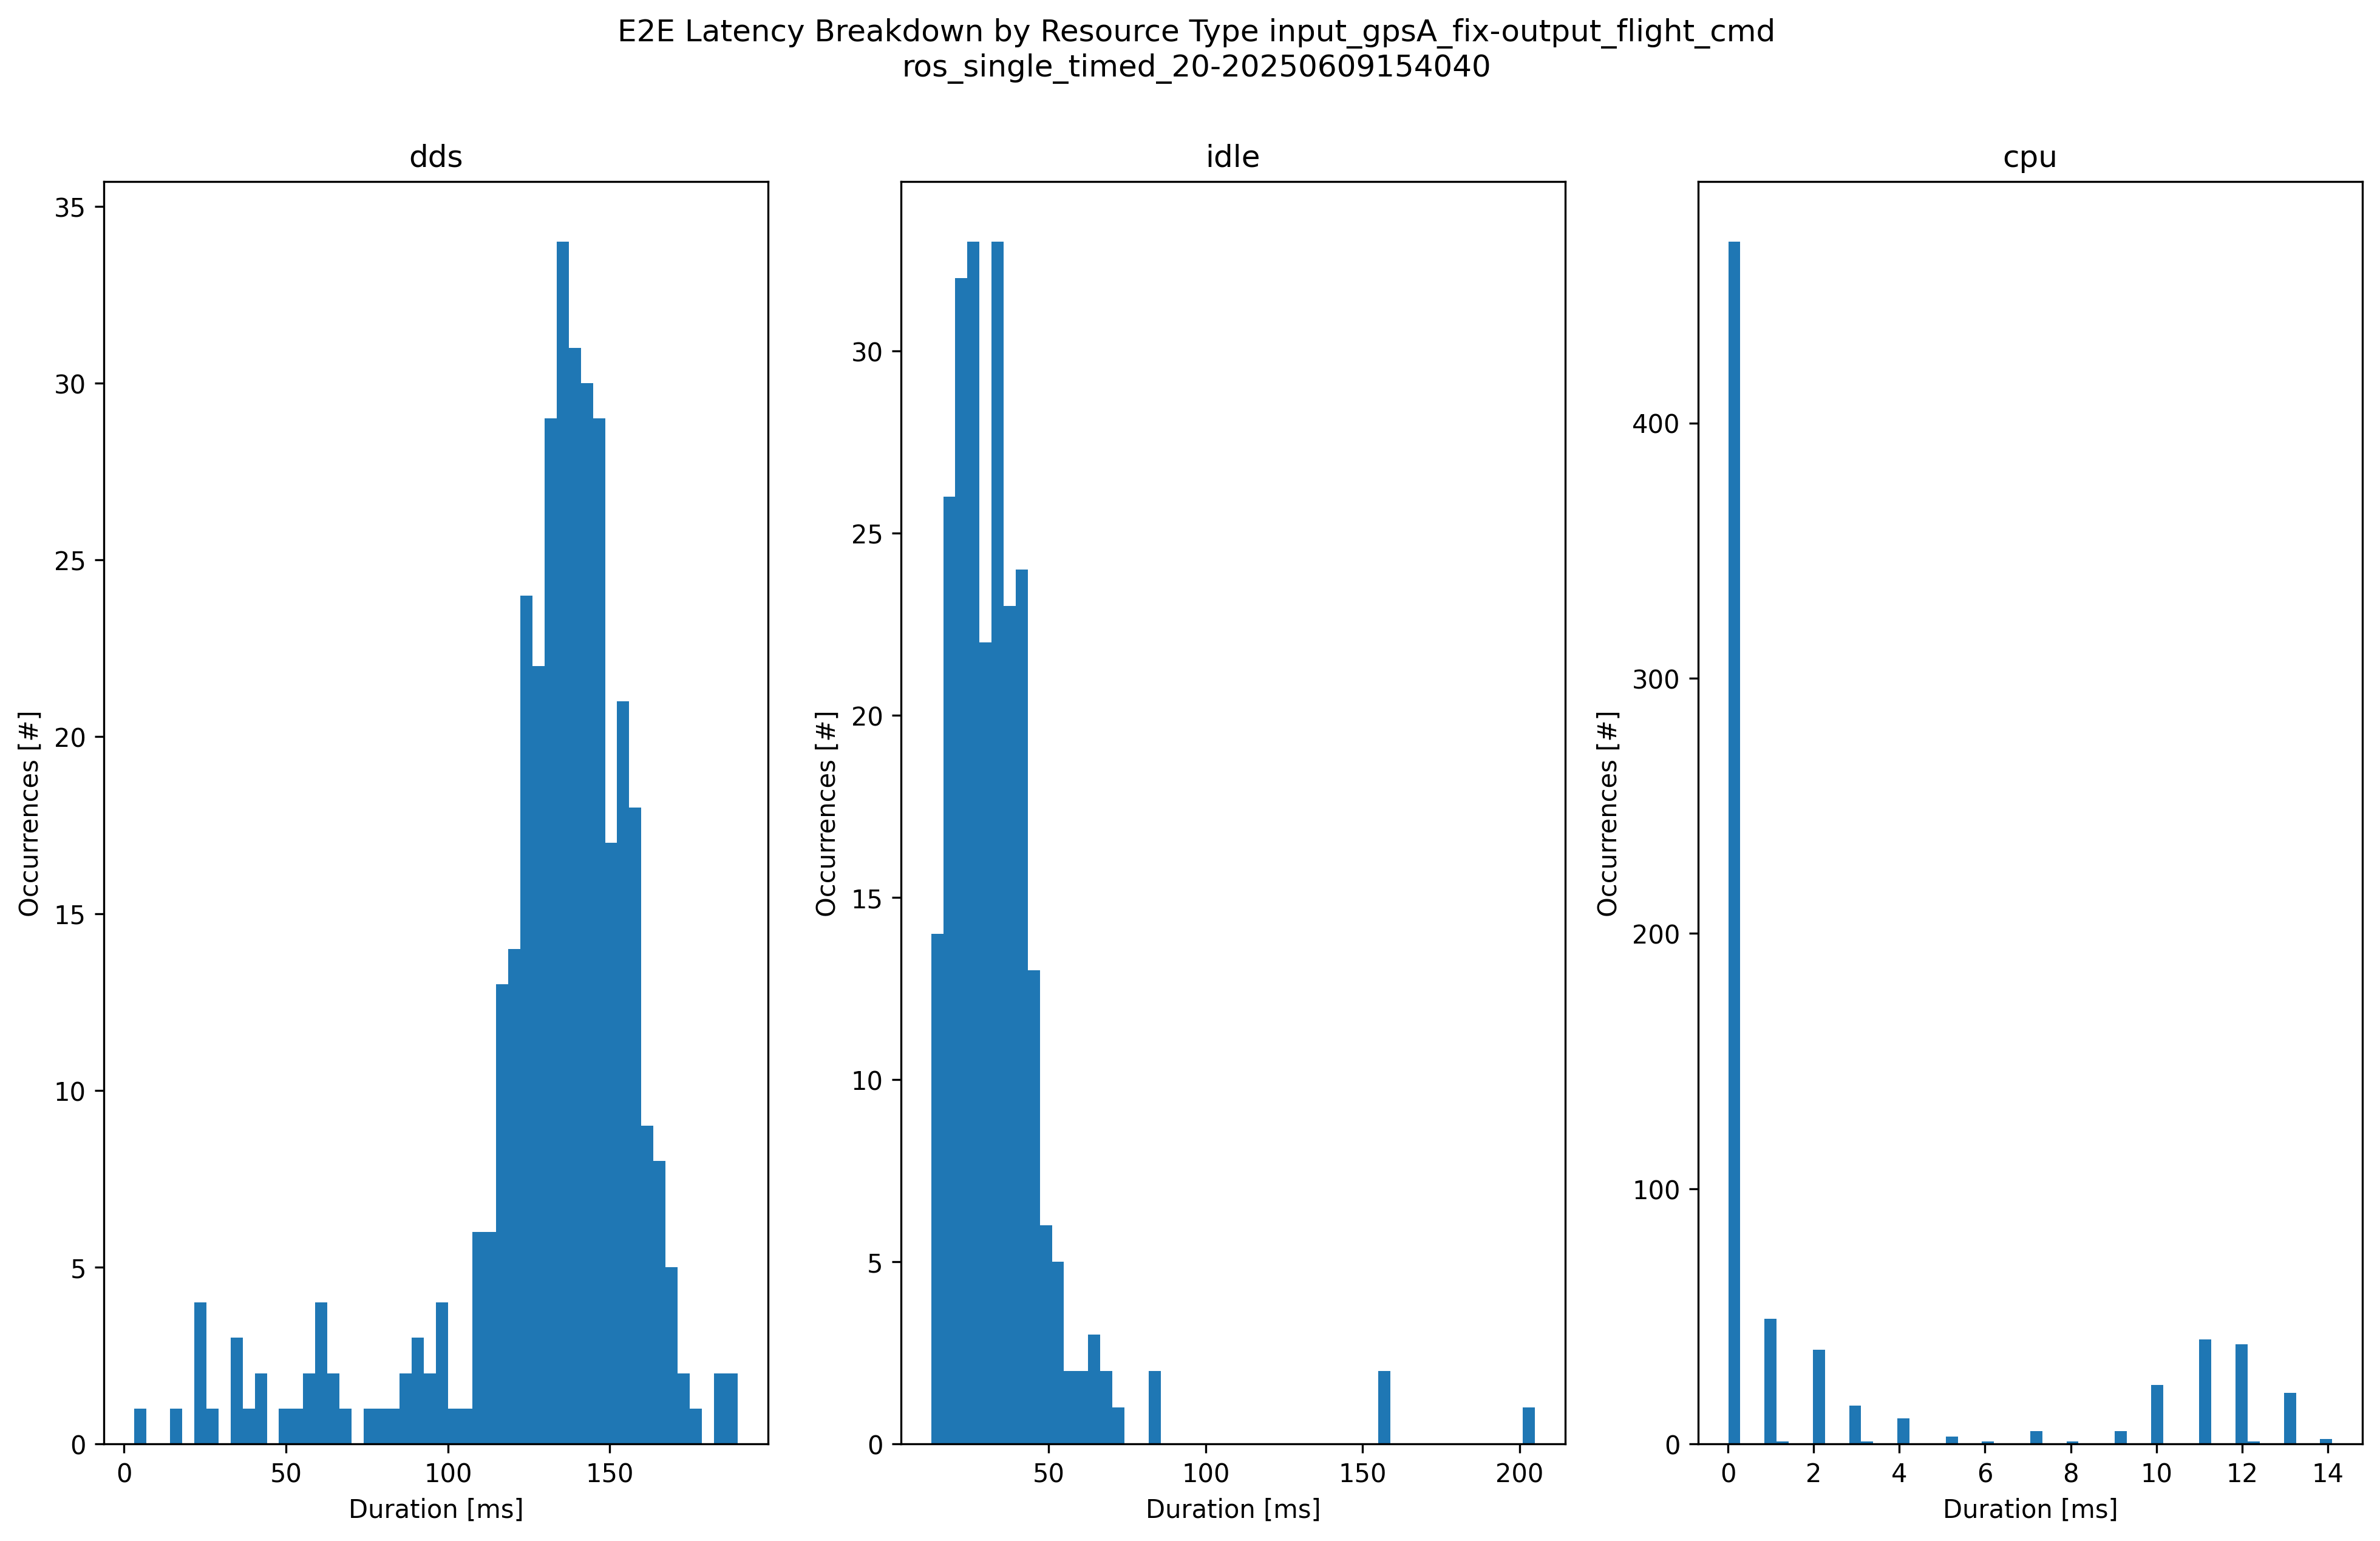

In [ ]:
import matplotlib.patches as mpatches
from collections import Counter

from message_tree.message_tree_algorithms import e2e_latency_breakdown, label_latency_item
from message_tree.message_tree_plots import e2e_breakdown_stack

##################################################
# 1. Filter DFG paths through must-be-included and cannot-be-included patterns
##################################################

cohorts_filt = {
    k: v for k, v in cohorts.items()
    if all(re.search(f.removeprefix("^").removesuffix("$"), k) for f in E2E_INCL_PATH_PATTERNS)
}

##################################################
# 2. Iterate through filtered DFG paths
##################################################

for relevant_path, relevant_dataflows in cohorts_filt.items():
    # Construct a filesystem-safe name for output files
    topics = [topic for topic in relevant_path.split(" -> ") if topic.startswith("/") and not topic.startswith("/void")]
    name = f"{topics[0][1:]}-{topics[-1][1:]}"
    name = name.replace("/", "_").replace(" ", "_").replace(":", "_")

    # Break down E2E latency for all dataflows on this path
    e2e_breakdowns = list(map(e2e_latency_breakdown, relevant_dataflows))
    flattened_breakdowns = [item for breakdown in e2e_breakdowns for item in breakdown]

    # Save information about the chosen path
    with open(os.path.join(OUT_PATH, f"plot_e2es_path_{name}.txt"), "w") as f:
        f.write(f"Number of path instances: {len(relevant_dataflows)}\n")
        f.write("    " + "\n -> ".join(relevant_path.split(" -> ")))
        f.write("\n")

    # Unique items for deduplicated analysis
    conv_items_unique = set(flattened_breakdowns)

    ##################################################
    # 3. Plot histograms of DDS/idle/cpu time breakdowns
    ##################################################
    def e2e_breakdown_type_hist(items):
        """
        For all e2e breakdown items (unique) of the form `("<type>", <duration>)`, plots a histogram for each encountered type (dds, idle, cpu).
        """
        plot_types = ("dds", "idle", "cpu")
        plt.close(f"E2E type breakdown histograms {name}\n{EXPERIMENT_NAME}")
        fig, axes = plt.subplots(1, 3, num=f"E2E type breakdown histograms {name}\n{EXPERIMENT_NAME}", dpi=300, figsize=(16, 9))
        fig.suptitle(f"E2E Latency Breakdown by Resource Type {name}\n{EXPERIMENT_NAME}")

        for plot_type, ax in zip(plot_types, axes):
            durations = [item.duration * 1000 for item in items if item.type == plot_type]
            df = pd.Series(durations)
            df.to_csv(
                os.path.join(OUT_PATH, f"plot_e2es_{plot_type}_portion_{name}.csv"),
                header=[f"e2e_latency_{plot_type}_portion_ms"],
                index=False
            )
            ax.set_title(plot_type)
            ax.hist(durations, bins=50)
            ax.set_xlabel("Duration [ms]")
            ax.set_ylabel("Occurrences [#]")
        return fig

    fig = e2e_breakdown_type_hist(conv_items_unique)
    plt.savefig(os.path.join(OUT_PATH, f"plot_e2e_portions_{name}.png"))

    ##################################################
    # 4. Plot histogram of all E2E latencies observed
    ##################################################
    e2e_latencies = [(path[-1].timestamp - path[0].timestamp) * 1000 for path in relevant_dataflows]
    pd.Series(e2e_latencies).to_csv(
        os.path.join(OUT_PATH, f"plot_e2es_{name}.csv"),
        index=False, header=["e2e_latency_ms"]
    )

    plt.close(f"E2E histogram {name}\n{EXPERIMENT_NAME}")
    fig, ax = plt.subplots(num=f"E2E histogram {name}\n{EXPERIMENT_NAME}", dpi=300, figsize=(16, 9))
    fig.suptitle(f"E2E Latency Histogram {name}\n{EXPERIMENT_NAME}")
    ax.hist(e2e_latencies, bins=30)
    ax.set_xlabel("E2E Latency [ms]")
    ax.set_ylabel("Occurrences [#]")
    mean_latency = np.mean(e2e_latencies)
    std_latency = np.std(e2e_latencies)
    min_latency = np.min(e2e_latencies)
    max_latency = np.max(e2e_latencies)
    ax.axvline(mean_latency, c="red", linewidth=2)
    _, max_ylim = ax.get_ylim()
    # Create a multi-line string with all stats
    stats_text = (
        f"Mean: {mean_latency:.2f} ms\n"
        f"Std:  {std_latency:.2f} ms\n"
        f"Min:  {min_latency:.2f} ms\n"
        f"Max:  {max_latency:.2f} ms"
    )
    # Place text near top right of plot
    ax.text(
        mean_latency * 1.02,        # or just use ax.get_xlim()[1]*0.98 for far right
        max_ylim * 0.98,            # near the top
        stats_text,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )
    plt.savefig(os.path.join(OUT_PATH, f"plot_e2es_{name}.png"))

    ##################################################
    # 5. Violin plot of per-component/stage latencies on the DFG path (across all dataflows)
    ##################################################
    plt.close("E2E path breakdown")
    fig, ax = plt.subplots(num=f"E2E path breakdown {name}\n{EXPERIMENT_NAME}", dpi=300, figsize=(16, 5))
    fig.suptitle(f"E2E Latency Path Breakdown {name}\n{EXPERIMENT_NAME}")

    component_breakdowns = [e2e_latency_breakdown(p) for p in tqdm(relevant_dataflows, desc="Calculating breakdowns")]
    # Transpose: Each element in component_durations is all values for one component
    component_durations = list(zip(*component_breakdowns))
    component_latency_items = component_durations

    def extract_class_name(symbol: str) -> str:
        # Try to extract class name in pattern: void(ClassName::ClassName...
        m = re.search(r'void\((\w+)::', symbol)
        if m:
            return m.group(1)
        # If pattern not found, fallback: find last word before first '('
        m = re.search(r'(\w+)\s*\(', symbol)
        if m:
            return m.group(1)
        return symbol  # fallback to original if all fails

    # For labeling, types etc (assume first dataflow is representative)
    labels = [extract_class_name(label_latency_item(item)) for item in e2e_latency_breakdown(relevant_dataflows[0])]
    print(f"Labels: {labels}")
    types = [item.type for item in e2e_latency_breakdown(relevant_dataflows[0])]
    # Convert durations from seconds to ms
    component_durations_ms = [list(map(lambda item: item.duration * 1000, d)) for d in component_durations]

    legend_entries = []

    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        legend_entries.append((mpatches.Patch(color=color), label))

    #counter = Counter(types)
    ## Print all unique elements and their count
    #for element, count in counter.items():
    #    print(f'{element}: {count}')

    for comp_type in ("idle", "dds", "cpu"):
        indices = [i for i, t in enumerate(types) if t == comp_type]
        xs = [component_durations_ms[i] for i in indices]
        if not xs:
            continue
        vln = ax.violinplot(xs, indices)
        add_label(vln, comp_type)
        # Export CSVs per component
        for i, x in zip(indices, xs):
            pd.Series(x).to_csv(
                os.path.join(OUT_PATH, f"plot_e2es_violin_{i:02d}.csv"),
                index=False, header=["duration_ms"]
            )
    ax.set_ylabel("Latency contribution [ms]")
    ax.set_xticks(range(len(labels)), labels, rotation=90)
    ax.legend(*zip(*legend_entries))
    plt.savefig(os.path.join(OUT_PATH, f"plot_e2es_violin_{name}.png"))

    # Save labels and types
    pd.Series(labels).to_csv(os.path.join(OUT_PATH, f"plot_e2es_violin_labels_{name}.csv"), index=False, header=["label"])
    pd.Series(types).to_csv(os.path.join(OUT_PATH, f"plot_e2es_violin_types_{name}.csv"), index=False, header=["type"])

    ##################################################
    # 6. Per-callback timestamp/duration records for relevant components (e.g., "cpu" stages)
    ##################################################
    for concat_pc_items in component_latency_items:
        # Defensive check
        if not isinstance(concat_pc_items[0].location[0], TrPublishInstance):
            continue
        records = [(item.location[0].timestamp, item.duration) for item in concat_pc_items]
        pd.DataFrame(records, columns=("timestamp", "duration")).to_csv(
            os.path.join(OUT_PATH, f"dur_ts_{concat_pc_items[0].location[0].publisher.topic_name.replace('/', '__')}_{name}.csv"),
            index=False
        )

    ##################################################
    # 7. Per-callback timing stats (mean, std, min, max) for "cpu" stages
    ##################################################
    cpu_indices = [i for i, t in enumerate(types) if t == "cpu"]
    cpu_durations = [np.array([item.location[0].duration for item in component_latency_items[i]]) for i in cpu_indices]
    cpu_labels = [labels[i] for i in cpu_indices]
    stats = [(lbl, x.mean(), x.std(), x.min(), x.max()) for x, lbl in zip(cpu_durations, cpu_labels)]
    pd.DataFrame(stats, columns=["callback", "mean", "std", "min", "max"]).to_csv(
        os.path.join(OUT_PATH, f"calc_times_{name}.csv"), index=False
    )

    ##################################################
    # 8. Stacked breakdown plot (from message_tree plots)
    ##################################################
    fig = e2e_breakdown_stack(*e2e_breakdowns, name=f"{name}\n{EXPERIMENT_NAME}")
    fig.set_size_inches(16, 9)
    fig.set_dpi(300)

print("Done.")